In [2]:
%pip install celluloid

  Using cached celluloid-0.2.0-py3-none-any.whl (5.4 kB)
Note: you may need to restart the kernel to use updated packages.


In [15]:
import jax
import jax.numpy as jnp
import jax.scipy as jsc
import matplotlib.pyplot as plt
import numpy as np
import pyhf
import optax
from jaxopt import OptaxSolver
import relaxed
from celluloid import Camera
from functools import partial

plt.rc("figure", figsize=(6, 3), dpi=220, facecolor="w")
plt.rc("legend", fontsize=8)

## Optimising a simple one-bin analysis

Let's define an analysis with a predicted number of signal and background events, with some uncertainty on the background estimate. We'll abstract the analysis configuration into a single parameter $\phi$ like so:

$$s = 15 + \phi $$
$$b = 45 - 2 \phi $$
$$\sigma_b = 0.01 + 0.1(\phi)^2 $$

Note that $s \propto \phi$ and $\propto -2\phi$, so increasing $\phi$ corresponds to increasing the signal/backround ratio. However, our uncertainty scales like $\phi^2$, so we're also going to compromise in our certainty of the background count as we do that. This kind of tradeoff between $s/b$ ratio and uncertainty is important for the discovery of a new signal, so we can't get away with optimising $s/b$ alone.

To illustrate this, we'll plot the discovery significance for this model with and without uncertainty.

In [46]:
# model definition
def yields(phi, uncertainty=True):
    s = 15 + phi
    b = 45 - 2 * phi
    db = (
        0.01 + 0.1 * phi**2 if uncertainty else jnp.zeros_like(phi) + 0.001
    )  # small enough to be negligible
    return jnp.asarray([s]), jnp.asarray([b]), jnp.asarray([db])


# our analysis pipeline, from phi to p-value
def pipeline(phi, return_yields=False, uncertainty=True):
    y = yields(phi, uncertainty=uncertainty)
    # use a dummy version of pyhf for simplicity + compatibility with jax
    model = relaxed.dummy_pyhf.uncorrelated_background(*y)
    nominal_pars = jnp.array([1.0, 1.0])
    data = model.expected_data(nominal_pars)  # we expect the nominal model
    # do the hypothesis test (and fit model pars with gradient descent)
    pvalue = relaxed.infer.hypotest(
        0.0,  # value of mu for the alternative hypothesis
        data,
        model,
        test_stat="q0",  # discovery significance test
        lr=1e-3,
        expected_pars=nominal_pars,  # we know our best-fit in advance
    )
    if return_yields:
        return pvalue, y
    else:
        return pvalue


# calculate p-values for a range of phi values
phis = jnp.linspace(0, 10, 100)

# with uncertainty
pipe = partial(pipeline, return_yields=True, uncertainty=True)
pvals, ys = jax.vmap(pipe)(phis)  # map over phi grid
# without uncertainty
pipe_no_uncertainty = partial(pipeline, uncertainty=False)
pvals_no_uncertainty = jax.vmap(pipe_no_uncertainty)(phis)

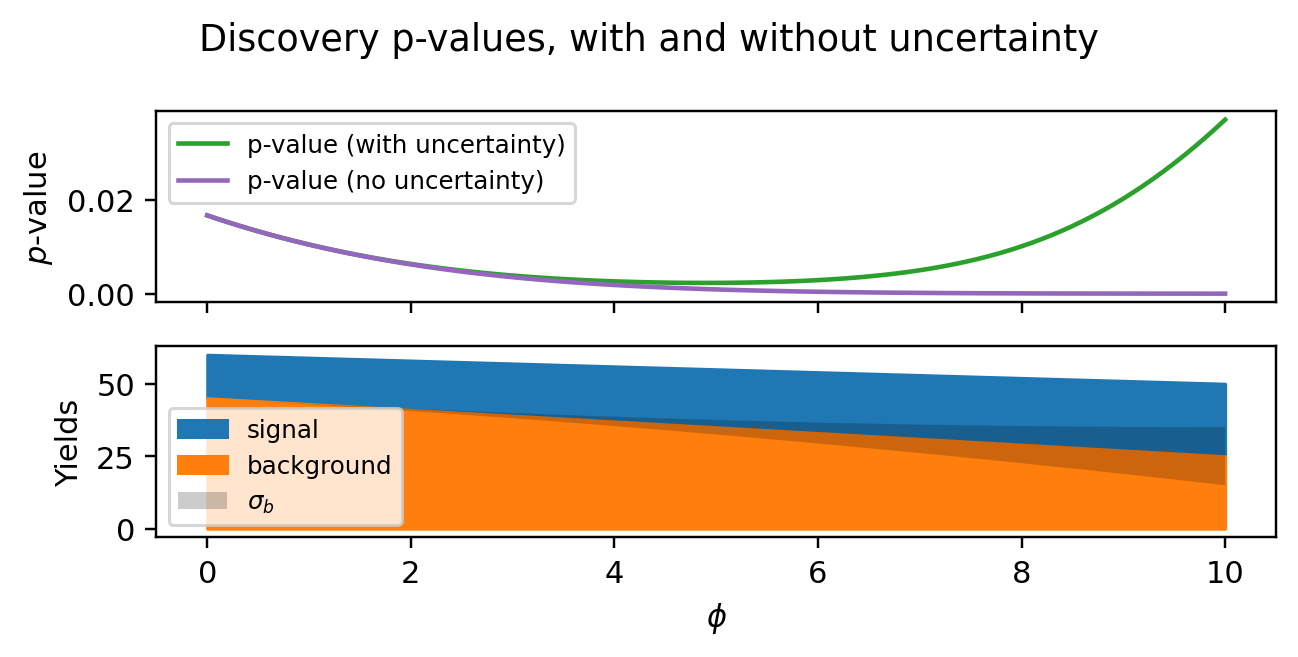

In [47]:
# plot them!
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(phis, pvals, label="p-value (with uncertainty)", color="C2")
axs[0].plot(phis, pvals_no_uncertainty, label="p-value (no uncertainty)", color="C4")
axs[0].set_ylabel("$p$-value")
axs[0].legend()
s, b, db = ys
s, b, db = s.ravel(), b.ravel(), db.ravel()  # everything is [[x]] for pyhf
axs[1].fill_between(phis, s + b, b, color="C0", label="signal")
axs[1].fill_between(phis, b, color="C1", label="background")
axs[1].fill_between(phis, b - db, b + db, facecolor="k", alpha=0.2, label=r"$\sigma_b$")
axs[1].set_xlabel("$\phi$")
axs[1].set_ylabel("Yields")
axs[1].legend(loc="lower left")
plt.suptitle("Discovery p-values, with and without uncertainty")
plt.tight_layout()